# Cloud-Hosted vs Local LLMs

In [ ]:
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama

import ollama
import json

from datetime import datetime

In [ ]:
# Run this cell if you've entered an API key in the .env file
import os
from dotenv import load_dotenv
load_dotenv()

# Check that you've set the environment variables correctly
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
print("OPENAI_API_KEY:", OPENAI_API_KEY)

In [ ]:
# Global configuration
OLLAMA_MODEL = "gemma3:1b"
COUNTRIES = ["Japan", "Norway", "Brazil"] 
EXIT_COMMANDS = {"exit", "quit", "end", "done", "bye"} # Specify some messages the user can enter to end the conversation.

In [ ]:
# Helper functions

def local_timestamp():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def ollama_messages(messages):
    """Strip custom fields before sending to Ollama."""
    return [{"role": m["role"], "content": m["content"]} for m in messages]

Some helpful CLI commands:

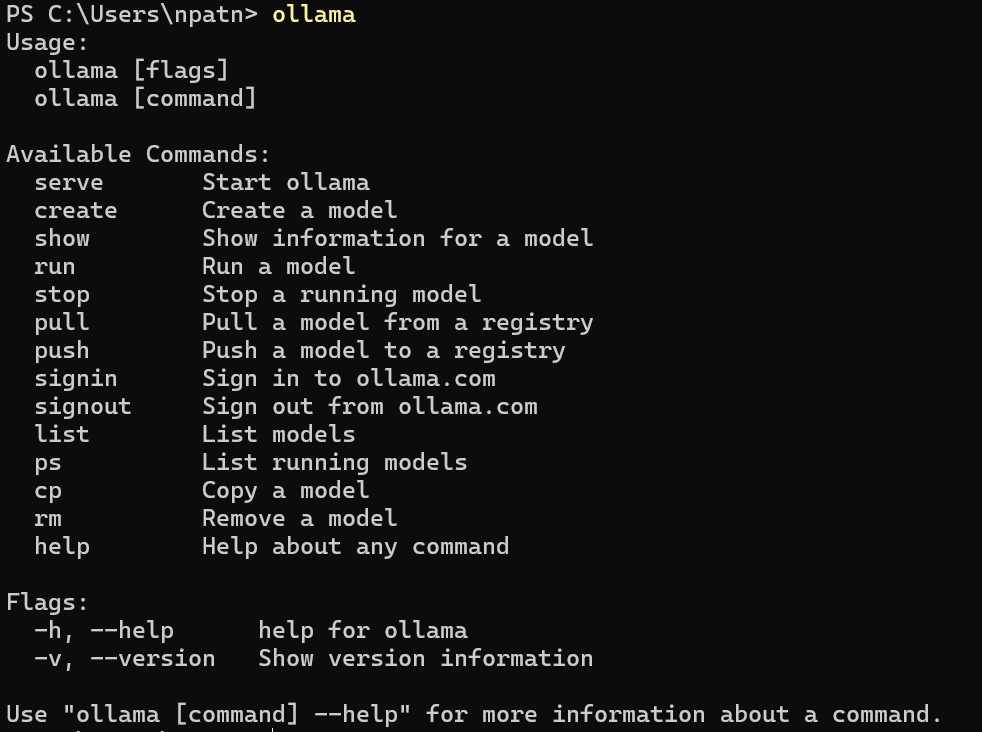

Let's try submitting a few different prompts to our downloaded model.

In [ ]:
# We're going to create a template prompt that can be invoked with different inputs.
template = "What is the capital of {country}?"
prompt = PromptTemplate(template=template, input_variables=["country"])

# Next, we create an instance of the ChatOllama class, specifying our model.
llm = ChatOllama(model=OLLAMA_MODEL)

# Finally, we can generate responses for different countries by formatting the prompt with different inputs.
for country in COUNTRIES:
    formatted_prompt = prompt.format(country=country)
    response = llm.invoke(formatted_prompt)
    print("----------------------------------")
    print(f"Q: {formatted_prompt}\nA: {response.content}\n")

In [ ]:
## The output of the .invoke method is an AIMessage object with a lot of metadata.
## You can explore all the attributes of the response object like this:
for attribute in dir(response):
    if not attribute.startswith("_"): # Ignore private attributes
        print(f"{attribute}: {getattr(response, attribute)}")
        print("-----")

## Chat with an Ollama Model

Now, let's use our downloaded model as a chatbot with a conversation history.

In [ ]:
# Define the conversation history as a list of messages (dictionaries).
# Aside from "content" that contains the actual text, Ollama uses "roles" to differentiate:
#   - system: instructions for the model
#   - user: messages entered by the user
#   - assistant: messages returned from the AI model
# You can also keep track of timestamps or other metadata if you want - but these won't be sent to the model.

messages = [
    {"role": "system", "content": "You are a helpful travel agent.", "timestamp": local_timestamp()},
    {"role": "user", "content": "Hello! I want to plan a vacation. Can you help me?", "timestamp": local_timestamp()},
]

message_counter = 1

# Start the conversation:
response = ollama.chat(model="gemma3:1b",  messages=ollama_messages(messages))
answer = response.message.content
print(f"Answer {message_counter}. Travel Agent Chatbot:", answer)
print("=" * 40, "\n")

# Store the answer in the conversation history
messages.append({"role": "assistant", "content": answer, "timestamp": local_timestamp()})

# Continue the conversation:
while True:

    user_input = input(f"You: ").strip()

    # If you enter a valid exit command, break the loop and end the conversation.
    if user_input.lower() in EXIT_COMMANDS:
        print("Ending the conversation. Goodbye!")
        break 

    # Update the conversation history with the user's input
    messages.append({"role": "user", "content": user_input, "timestamp": local_timestamp()})
    message_counter += 1

    # Get the model's response and display it
    response = ollama.chat(model="gemma3:1b", messages=ollama_messages(messages))
    answer = response.message.content
    print(f"Answer {message_counter}. Travel Agent Chatbot:", answer)
    print("=" * 60, "\n")

    # Update the conversation history with the model's response
    messages.append({"role": "assistant", "content": answer, "timestamp": local_timestamp()})

In [ ]:
# We can save the conversation history to a JSON file for later use.
with open("travel_agent_conversation_history.json", "w") as f:
    json.dump(messages, f, indent=2)

# Read the conversation history back from the JSON file
with open("travel_agent_conversation_history.json", "r") as f:
    loaded_messages = json.load(f)

for msg in loaded_messages:
    timestamp = msg.get("timestamp", "N/A")
    role = msg["role"].capitalize()
    content = msg["content"]

    print(f"[{timestamp}] {role}: {content}\n")

## Enforce structured outputs from an Ollama model

Adapted example from Ollama Documentation, available at https://docs.ollama.com/.

In [ ]:
from ollama import chat
from pydantic import BaseModel

class Pet(BaseModel):
  name: str
  animal: str
  age: int
  color: str | None
  favorite_toy: str | None

class PetList(BaseModel):
  pets: list[Pet]

response = chat(
  model='gemma3:1b',
  messages=[{'role': 'user', 'content': 'I have two dogs. One of them is named Billy. The other is 2 years old.'}],
  format=PetList.model_json_schema(),
)

# Notice that the missing information seems random...
# Seems like we'll need do to some more work to get reliable structured outputs :)
pets = PetList.model_validate_json(response.message.content)
for pet in pets.pets:
    print(pet)

## OPTIONAL: Using the OpenAI API

Documentation here: https://platform.openai.com/docs/quickstart. 

In [ ]:
from openai import OpenAI

try:
    # The OpenAI() constructor automatically looks for OPENAI_API_KEY in the environment
    client = OpenAI()

    response = client.responses.create(model="gpt-5-nano",
                                       input="Tell me a fun fact about the city of Boston.")
    print(response.output_text)

except Exception as e:
    # This will catch missing API key, auth errors, and similar setup issues
    print("OpenAI API not available (no API key or authentication failed).")
    print("Details:", str(e))
